In [1]:
import numpy as np 
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
   

In [2]:
tickers = ['TCS.NS','WIPRO.NS','MINDTREE.NS']
start = "2000-01-01"
end = "2018-09-06"

[*********************100%***********************]  3 of 3 downloaded


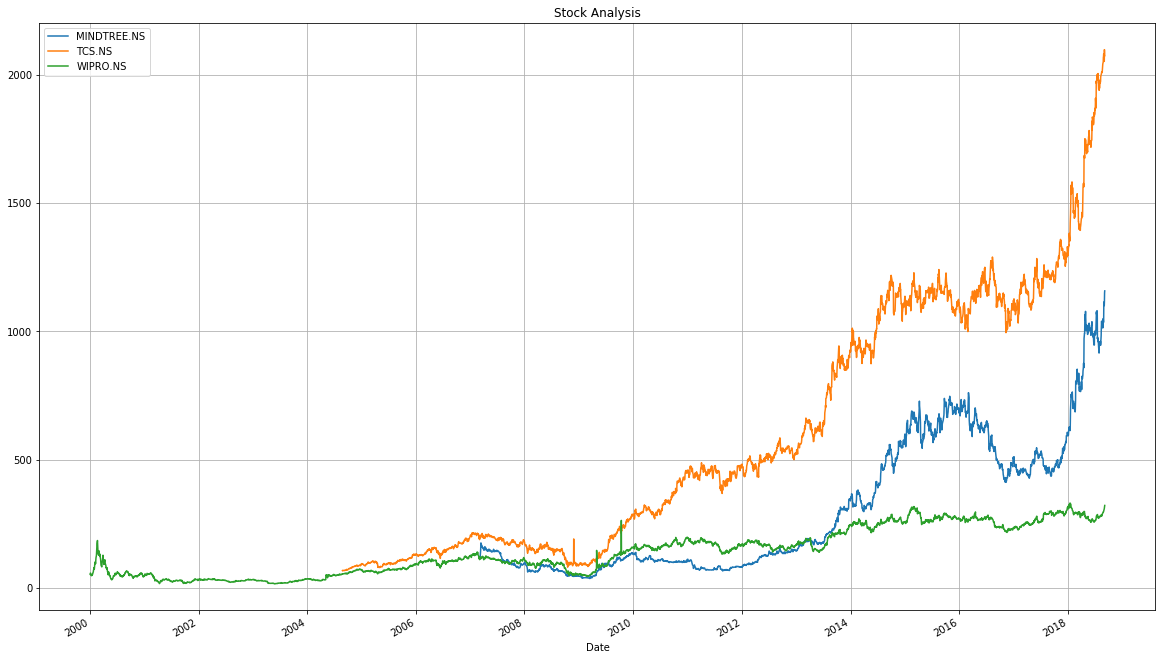

In [3]:
DF = pdr.get_data_yahoo(tickers,start,end)
FilteredDF = DF["Adj Close"]
FilteredDF.plot(figsize=(20, 12),title="Stock Analysis",grid = True);

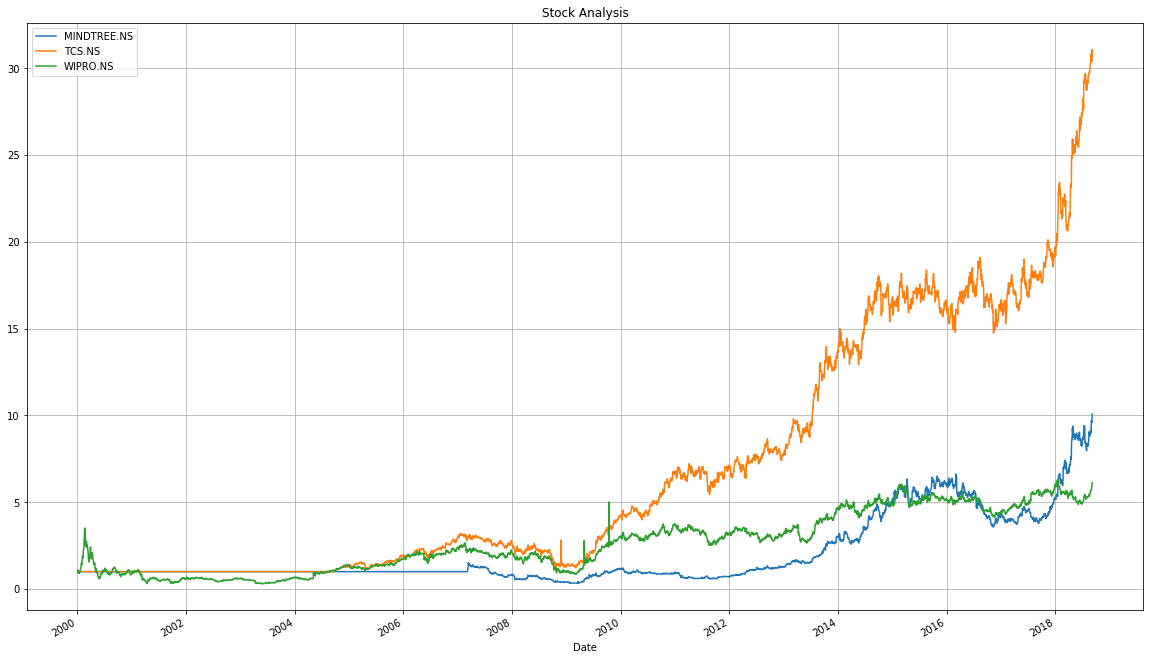

In [4]:
FilteredDF.bfill(inplace = True)
NormalizedDF = FilteredDF.apply(lambda x: x/x[0])
NormalizedDF.plot(figsize=(20, 12),title="Stock Analysis",grid = True);

In [5]:
StockToAnalyze = 'MINDTREE.NS'

RollingMeanFiltered_20d = FilteredDF[StockToAnalyze].rolling(window = 20).mean()
RollingMeanFiltered_50d = FilteredDF[StockToAnalyze].rolling(window = 50).mean()
RollingMeanFiltered_200d = FilteredDF[StockToAnalyze].rolling(window = 200).mean()

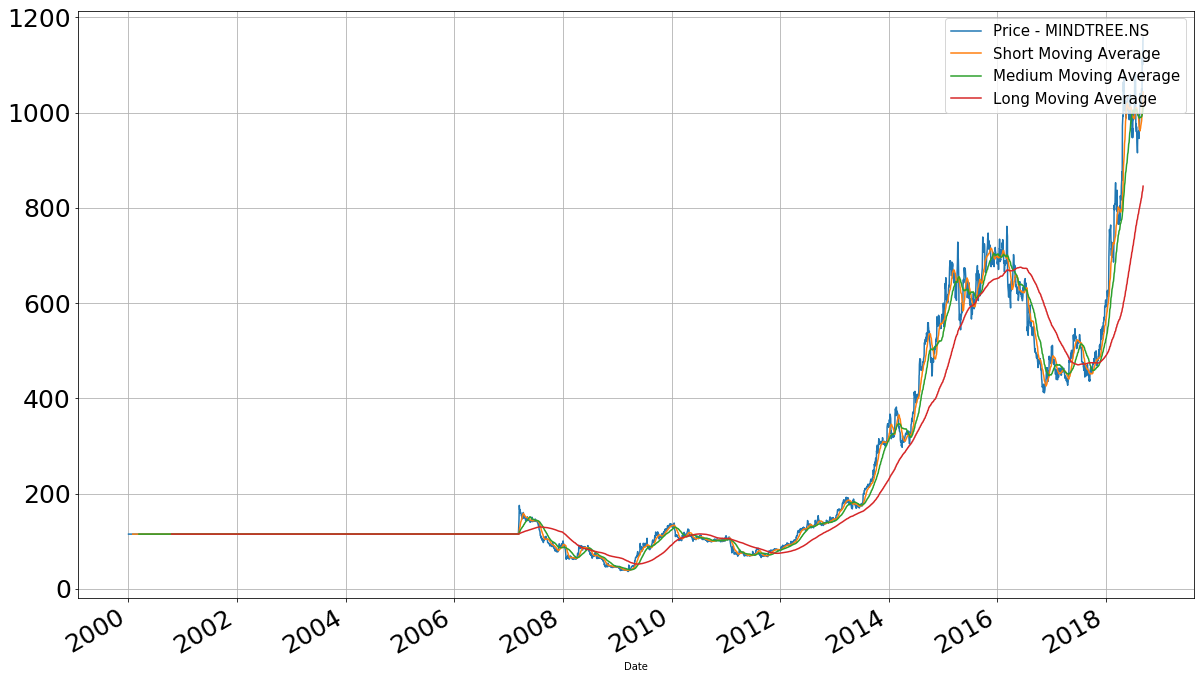

In [6]:
ax = FilteredDF[StockToAnalyze].plot(figsize=(20, 12),label="Price - " + StockToAnalyze,grid=True)
RollingMeanFiltered_20d.plot(figsize=(20,12),fontsize=25,label="Short Moving Average",ax=ax,grid = True);
RollingMeanFiltered_50d.plot(figsize=(20,12),fontsize=25,label="Medium Moving Average",ax=ax,grid = True);
RollingMeanFiltered_200d.plot(figsize=(20,12),fontsize=25,label="Long Moving Average",ax=ax,grid = True);
plt.legend(loc='upper right',fontsize=15)

# Trading Strategy :

A trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later.

In [7]:
StockToAnalyze = 'MINDTREE.NS'

Stock = pd.DataFrame(FilteredDF[StockToAnalyze])
Stock["50d"] = FilteredDF[StockToAnalyze].rolling(window = 50).mean()
Stock["200d"] = FilteredDF[StockToAnalyze].rolling(window = 200).mean()
Stock["50d-200d"] = Stock["50d"]-Stock["200d"]


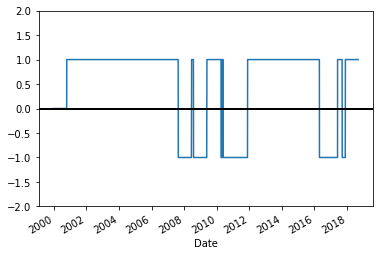

In [8]:
Stock["Regime"] = np.where(Stock['50d-200d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
Stock["Regime"] = np.where(Stock['50d-200d'] < 0, -1, Stock["Regime"])
Stock['Regime'].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [9]:
Stock['Regime'].value_counts()

 1    3317
-1    1112
 0     199
Name: Regime, dtype: int64

Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

It's simple to obtain signals. Let r_t indicate the regime at time t, and s_t the signal at time t. Then:

s_t = \text{sign}(r_t - r_{t - 1})

s_t \in \{-1, 0, 1\}, with -1 indicating "sell", 1 indicating "buy", and 0 no action. We can obtain signals like so:

In [10]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = Stock.loc[:, "Regime"].iloc[-1]
Stock.loc[:, "Regime"].iloc[-1] = 0
Stock["Signal"] = np.sign(Stock["Regime"] - Stock["Regime"].shift(1))
# Restore original regime data
Stock.loc[:, "Regime"].iloc[-1] = regime_orig


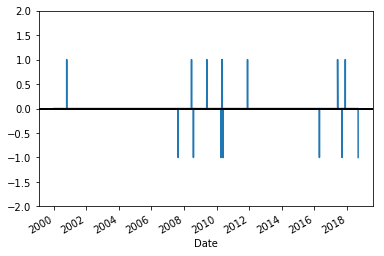

In [11]:
Stock['Signal'].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [12]:
Stock['Signal'].value_counts()

 0.0    4611
-1.0       8
 1.0       8
Name: Signal, dtype: int64

In [13]:
Stock.loc[Stock["Signal"] == 1]

,MINDTREE.NS,50d,200d,50d-200d,Regime,Signal
Date,,,,,,
2000-10-19,114.839386,114.839386,114.839386,2.273737e-13,1,1.0
2008-06-16,88.421738,83.352692,83.160173,1.925192e-01,1,1.0
2009-05-25,73.007385,52.624045,52.057920,5.661248e-01,1,1.0
2010-04-28,123.607529,111.610192,111.590507,1.968489e-02,1,1.0
2010-05-06,112.535599,112.271046,112.175561,9.548499e-02,1,1.0
2011-11-23,81.670235,74.891116,74.786516,1.046003e-01,1,1.0
2017-06-02,528.985352,472.915286,472.486792,4.284936e-01,1,1.0
2017-11-22,513.961792,477.296323,476.169402,1.126922e+00,1,1.0


In [14]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
MindTree_signals = pd.concat([
        pd.DataFrame({"Price": Stock.loc[Stock["Signal"] == 1, "MINDTREE.NS"],
                     "Regime": Stock.loc[Stock["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": Stock.loc[Stock["Signal"] == -1, "MINDTREE.NS"],
                     "Regime": Stock.loc[Stock["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
MindTree_signals.sort_index(inplace = True)
MindTree_signals

,Price,Regime,Signal
Date,,,
2000-10-19,114.839386,1,Buy
2007-08-22,98.012993,-1,Sell
2008-06-16,88.421738,1,Buy
2008-07-29,68.469368,-1,Sell
2009-05-25,73.007385,1,Buy
2010-04-09,112.226410,-1,Sell
2010-04-28,123.607529,1,Buy
2010-04-29,111.182991,-1,Sell
2010-05-06,112.535599,1,Buy


# Let's see the profitability of long trades

In [15]:
MindTree_long_profits = pd.DataFrame({
        "Price": MindTree_signals.loc[(MindTree_signals["Signal"] == "Buy") &
                                  MindTree_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(MindTree_signals["Price"] - MindTree_signals["Price"].shift(1)).loc[
            MindTree_signals.loc[(MindTree_signals["Signal"].shift(1) == "Buy") & (MindTree_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": MindTree_signals["Price"].loc[
            MindTree_signals.loc[(MindTree_signals["Signal"].shift(1) == "Buy") & (MindTree_signals["Regime"].shift(1) == 1)].index
        ].index
    })
MindTree_long_profits

,Price,Profit,End Date
Date,,,
2000-10-19,114.839386,-16.826393,2007-08-22
2008-06-16,88.421738,-19.952370,2008-07-29
2009-05-25,73.007385,39.219025,2010-04-09
2010-04-28,123.607529,-12.424538,2010-04-29
2010-05-06,112.535599,-8.231499,2010-05-26
2011-11-23,81.670235,605.697014,2016-04-21
2017-06-02,528.985352,-93.004975,2017-09-12
2017-11-22,513.961792,644.038208,2018-09-06


In [17]:
MindTree_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         })
cash =  99910.27 
port_value = 1  # Max proportion of portfolio bet on any trade 


for index, row in MindTree_long_profits.iterrows():
    NofStock = np.floor(cash * port_value) // row["Price"] # Maximum number of stocks invested in
    trade_val = NofStock * row["Price"] # How much money is put on the line with each trad
    share_profit = row["Profit"]
    profit = share_profit * NofStock # How much money is put on the line with each trade

    MindTree_backtest = MindTree_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": NofStock,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                }, index = [index]))
    cash = max(0, cash + profit)
 
MindTree_backtest

,Start Port. Value,End Port. Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit
2000-10-19,99910.270000,8.528813e+04,2007-08-22,869.0,114.839386,99795.426434,-16.826393,-14622.135517
2008-06-16,85288.134483,6.605405e+04,2008-07-29,964.0,88.421738,85238.555432,-19.952370,-19234.084680
2009-05-25,66054.049803,1.015080e+05,2010-04-09,904.0,73.007385,65998.676040,39.219025,35453.998600
2010-04-28,101508.048403,9.130750e+04,2010-04-29,821.0,123.607529,101481.781309,-12.424538,-10200.545698
2010-05-06,91307.502705,8.463176e+04,2010-05-26,811.0,112.535599,91266.370789,-8.231499,-6675.745689
2011-11-23,84631.757016,7.121339e+05,2016-04-21,1036.0,81.670235,84610.363460,605.697014,627502.106504
2017-06-02,712133.863520,5.869492e+05,2017-09-12,1346.0,528.985352,712014.283792,-93.004975,-125184.696350
2017-11-22,586949.167170,1.322441e+06,2018-09-06,1142.0,513.961792,586944.366464,644.038208,735491.633536


In [109]:
commulativeReturn = pd.DataFrame({"Date": [],
                         "CashFlow": []
                         })

commulativeReturn = commulativeReturn.append(pd.DataFrame({
                "Date": MindTree_backtest.index.tolist(),
                "CashFlow":MindTree_backtest["Start Port. Value"]}
                ))

commulativeReturn = commulativeReturn.append(pd.DataFrame({
                "Date": MindTree_backtest["End Date"],
                "CashFlow": MindTree_backtest["End Port. Value"]*-1}
                ))
commulativeReturn.reset_index(drop=True,inplace=True)
commulativeReturn['xrli']=list(zip(commulativeReturn.Date,commulativeReturn.CashFlow))
commulativeReturn.sort_values(by ='Date',inplace=True)
commulativeReturn

,Date,CashFlow,xrli
0,2000-10-19,9.991027e+04,"(2000-10-19 00:00:00, 99910.27)"
8,2007-08-22,-8.528813e+04,"(2007-08-22 00:00:00, -85288.134483)"
1,2008-06-16,8.528813e+04,"(2008-06-16 00:00:00, 85288.134483)"
9,2008-07-29,-6.605405e+04,"(2008-07-29 00:00:00, -66054.049803)"
2,2009-05-25,6.605405e+04,"(2009-05-25 00:00:00, 66054.049803)"
10,2010-04-09,-1.015080e+05,"(2010-04-09 00:00:00, -101508.04840300002)"
3,2010-04-28,1.015080e+05,"(2010-04-28 00:00:00, 101508.04840300002)"
11,2010-04-29,-9.130750e+04,"(2010-04-29 00:00:00, -91307.502705)"
4,2010-05-06,9.130750e+04,"(2010-05-06 00:00:00, 91307.502705)"
12,2010-05-26,-8.463176e+04,"(2010-05-26 00:00:00, -84631.757016)"


In [111]:
import datetime
from scipy import optimize

def xnpv(rate,cashflows):
    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0] #t0 is the date of the first cash flow
    
    return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])

def xirr(cashflows,guess=0.1):
    return optimize.newton(lambda r: xnpv(r,cashflows),guess) 

#commulativeReturn
print(xirr(commulativeReturn.xrli)*100,"%")

17.0796306707686 %
